# Lensing Code Anlaysis

## Imports

In [1267]:
# import some standard libraries

import sys
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import latex as tex
import scipy
from scipy.optimize import curve_fit
from astropy.cosmology import wCDM
import astropy.cosmology as cosmo
from pprint import pprint
import astropy.units as u
from ctypes import *
import random
from scipy.optimize import least_squares



# import the lenspack library
# https://cosmostat.github.io/lenspack/index.html

import lenspack as lp

# Set some plotting parameters

In [1268]:
# plot default parameters

print(plt.rcParams.keys())  # gives all parameters 

def set_pub():
    plt.rcParams.update({
        "font.size": 20,        # font size
        "figure.figsize":(9, 8),# figure size
        "lines.linewidth": 2,
        "font.weight": "bold",  # bold fonts
        "text.usetex": True,
        "font.family": 'serif'
    })

set_pub()



KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

# Load the synthetic lensing data

In [1269]:
# root1 = 'DATA/'
    
# infile = root1+'SIS_Shear_Data.v1.SMALL.dat'
    
# f = open(infile, 'r')
# line = f.readline()
# columns = line.split()
# ngal=columns[0]
# print(type(ngal))
# ngal=int(columns[0])
# print(type(ngal))

In [1270]:
# root1 = 'DATA/'
    
# infile = root1+'SIS_Shear_Data.v1.SMALL.dat'
    
# f = open(infile, 'r')
# line = f.readline()
# columns = line.split()
# ngal=columns[0]
# ngal=int(columns[0])


In [1271]:
# posx=np.zeros(ngal)
# posy=np.zeros(ngal)

# gam1_s=np.zeros(ngal)
# gam2_s=np.zeros(ngal)

# gam1_r=np.zeros(ngal)
# gam2_r=np.zeros(ngal)

# gam1_sr=np.zeros(ngal)
# gam2_sr=np.zeros(ngal)

# #e1_r=np.zeros(ngal)
# #e2_r=np.zeros(ngal)
# #e1_s=np.zeros(ngal)
# #e2_s=np.zeros(ngal)
# #e1_sr=np.zeros(ngal)
# #e2_sr=np.zeros(ngal)

# for i in range(ngal):
#     line = f.readline()
#     columns = line.split()
#     posx[i] = columns[0]
#     posy[i] = columns[1]
#     gam1_s[i] = columns[2]
#     gam2_s[i] = columns[3]
#     gam1_r[i] = columns[4]
#     gam2_r[i] = columns[5]
#     gam1_sr[i] = columns[6]
#     gam2_sr[i] = columns[7]
    
# print(type(posx))


### Code for the large data set

In [1272]:
class HeadStruct(Structure):
    _fields_ = [('Ngal', c_longlong),
                ('xL1', c_double),
                ('yL1', c_double),
                ('xL2', c_double),
                ('yL2', c_double),
                ('dummy1', c_double),
                ('dummy2', c_double),
                ('Ltheta1', c_double),
                ('Ltheta2', c_double),
                ('SurveyArea', c_double),
                ('SourceDensity', c_double),
                ('ShapeNoise', c_double),
                ('dummy3', c_double),
                ('dummy4', c_double),
                ('z_l', c_double),
                ('z_s', c_double),
                ('z_o', c_double),
                ('dummy5', c_double),
                ('dummy6', c_double),
                ('dummy7', c_double)]
    
class CosmoStruct(Structure):
    _fields_ = [('om_m', c_double),
                ('om_r', c_double),
                ('om_b', c_double),
                ('om_cdm', c_double),
                ('om_nu', c_double),
                ('om_de', c_double),
                ('om_k', c_double),
                ('w0', c_double),
                ('wa', c_double),
                ('H', c_double),
                ('fbaryon', c_double),
                ('fcdm', c_double)]    
    
    
class GalLensStruct(Structure):
    _fields_ = [('posx', c_double),
                ('posy', c_double),
                ('gam1_s', c_double),
                ('gam2_s', c_double),
                ('gam1_r', c_double),
                ('gam2_r', c_double),
                ('gam1_sr', c_double),
                ('gam2_sr', c_double),
                ('e1_s', c_double),
                ('e2_s', c_double),
                ('e1_r', c_double),
                ('e2_r', c_double),
                ('e1_sr', c_double),
                ('e2_sr', c_double),
                ('flag', c_int)]    

                
with open('DATA/SIS_Shear_Data.v1.dat', 'rb') as file:

    head = HeadStruct()
    file.readinto(head)

    cp = CosmoStruct()
    file.readinto(cp)
    
    GLens = []
    for i in range(head.Ngal):
        GLens.append(GalLensStruct())
        file.readinto(GLens[i])
    
print(head.Ngal,head.z_l)
print(cp.om_m,cp.w0)
print(GLens[600].posx,GLens[600].posy)

posx=np.zeros(head.Ngal)
posy=np.zeros(head.Ngal)

gam1_s=np.zeros(head.Ngal)
gam2_s=np.zeros(head.Ngal)

gam1_r=np.zeros(head.Ngal)
gam2_r=np.zeros(head.Ngal)

gam1_sr=np.zeros(head.Ngal)
gam2_sr=np.zeros(head.Ngal)

for i in range(head.Ngal):
    posx[i]    = GLens[i].posx
    posy[i]    = GLens[i].posy
    gam1_s[i]  = GLens[i].gam1_s
    gam2_s[i]  = GLens[i].gam1_s
    gam1_r[i]  = GLens[i].gam1_r
    gam2_r[i]  = GLens[i].gam2_r
    gam1_sr[i] = GLens[i].gam1_sr
    gam2_sr[i] = GLens[i].gam2_sr

print(posx[800],posy[800])


108000 0.3
0.3 -1.0
0.0037837622758070868 -0.0018739853809178779
-0.008159744105015052 0.007020304309567618


# My Code 

### Description of variables

In [1273]:
"""
   theta : 2d vector 
      Theta is our 2d position for the lens plane in radians

   eta : 2d vector
      Eta is our 2d position for the lens plane in real distances
"""

'\n   theta : 2d vector \n      Theta is our 2d position for the lens plane in radians\n\n   eta : 2d vector\n      Eta is our 2d position for the lens plane in real distances\n'

### Todo

- [*] Error Bars on plot
- [*] Fit the plot
- [*] Write function that calculate D_d, D_s and D_ds given some redshift
- [*] Sigma_Vˆ2
- [-] 3 plots for each pure, noise, pure and noise
- [*] Surface Mass Density Function 
- [*] Calcuate Sigma Crit
- [*] Add Error Bars to all plots
- [*] Add the functionality to remove empty bins to all shear calc functions
- [ ] Error on Sigma_V^2
- [ ] Error on Mass

### Calculate Lenspack Tangential and Cross Shear

In [1274]:
gam_t_s_LP, gam_x_s_LP=lp.shear.gamma_tx(posx,posy,gam1_s,gam2_s)       # Calculates the tangetial shear for the pure signal
gam_t_r_LP, gam_x_r_LP=lp.shear.gamma_tx(posx,posy,gam1_r,gam2_r)       #                                     .. pure random (pure noise)
gam_t_sr_LP, gam_x_sr_LP=lp.shear.gamma_tx(posx,posy,gam1_sr,gam2_sr)   #                                     .. signal and noise


### Define theta

In [1275]:
# Defines our angular position vector theta
theta = np.column_stack((posx, posy))

## Define Functions

#### Shear Calculation Functions

In [1276]:
def Shear(theta, gamma1, gamma2):
    """
    Calculates both the cross and tangential shear for each position.

    gamma_t = -Re[gamma * exp(-2i * phi)]
    gamma_x = -Im[gamma * exp(-2i * phi)]


    Paramaters: 
        theta : 2d float array
            Theta is the angular position of each star. [x, y] 
    
        gamma1 : float
            shear in the x direction

        gamma2 : float
            shear in the y direction

    Returns: 
        gamma_t : float array
            Tangential Shear values

        gamma_x : float array
            Cross Shear values
    """

    gamma_t = []
    gamma_x = []
    
    for i in range(len(posx)):

        mag_theta = np.sqrt(np.square(theta[i][0]) + np.square(theta[i][1]))
        
        gamma = gamma1[i] + 1j * gamma2[i]
        
        if theta[i][1] >= 0:
            phi = np.arccos(posx[i] / mag_theta)

        else:
            phi = - np.arccos(posx[i] / mag_theta)      

        gamma_t.append(
            - np.real(gamma * np.exp(-2j * phi))
            )
        gamma_x.append(
            - np.imag(gamma * np.exp(-2j * phi))
        )

    return gamma_t, gamma_x 
        



In [1277]:
def TangentialShearRingAverage(theta_array, gamma_t, signal_type):
    """
    Calculate the Ring Average of the Tangential Shear. 

    Paramaters: 
        theta_array : float
            Array of radial components of the position

        gamma_t : float
            Array of tangential shears  

        signal_type : string
            allows us to calculate the errors differently for a pure, noise, and noise + pure signal

    Returns: 
        bin_centres : float     
            This is the radial component of the position for which the ring average (bin_average) is calculated for

        bin_averages : float
            Ring average for the bin
    """

    bin_centres, bin_averages, bin_errors = RadialBinningMethod(theta_array, gamma_t, signal_type)

    bin_centres, bin_averages, bin_errors = RemoveEmptyBins(bin_centres, bin_averages, bin_errors)

    return [bin_centres, bin_averages, bin_errors]


In [1278]:
def KappaRingAverage(theta, einstien_limit, signal_type):
    """
    Calculate Kappa - the convergence.
    
    Paramaters: 
        theta : float array
            Is the magnitude position from the origin in radians        

        einstien_limit : float
            Einstien Limit
    
    Returns:
        kappa : float array 
            array of kappa values for theta values
    """
    einstien_limit_  = np.ones((len(theta)))
    einstien_limit_ *= einstien_limit

    kappa = einstien_limit_ / (2 * theta)
    

    bin_centres, bin_averages, bin_errors = RadialBinningMethod(theta, kappa, signal_type)

    bin_centres, bin_averages, bin_errors = RemoveEmptyBins(bin_centres, bin_averages, bin_errors)

    return [bin_centres, bin_averages, bin_errors]



In [1279]:
def Kappa(theta, einstein_limit, einstein_limit_err):
    """
    Calculate Kappa - the convergence.
    
    Paramaters: 
        theta : float array
            Is the magnitude position from the origin in radians        

        einstein_limit : float
            Einstein Limit
    
    Returns:
        kappa : float array 
            array of kappa values for theta values
    """
    
    einstein_limit_  = np.ones((len(theta)))
    einstein_limit_ *= einstein_limit

    kappa = einstein_limit_ / (2 * theta)

    kappa_err = np.ones((len(theta)))/(2*theta) * einstein_limit_err

    return [theta, kappa, kappa_err]

In [1280]:
def KappaBar(theta, einstien_limit, signal_type):
    """
    Calculates Kappa Bar.
    
    Paramaters: 
        theta : vector2 array
            Is our position vector from the origin in radians        

        einstien_limit : float
            Einstien Limit
    
    Returns:
        kappa_bar : float array 
            array of kappa_bar values for theta values
    """

    einstien_limit_  = np.ones((len(theta)))
    einstien_limit_ *= einstien_limit

    kappa_bar = einstien_limit_ / theta


    bin_centres, bin_averages, bin_errors = RadialBinningMethod(theta, kappa_bar, signal_type)

    bin_centres, bin_averages, bin_errors = RemoveEmptyBins(bin_centres, bin_averages, bin_errors)

    return [bin_centres, bin_averages, bin_errors]


#### Binning Functions

In [1281]:
def RadialBinningMethod(theta, y, signal_type, Nbins=16):
    bin_starts, bin_centres, bins, bin_averages, delta_theta = CreateLogScaleBins(theta, Nbins)
    print(len(bin_starts))
    bin_errors = np.array([])

    for i_bin in range(len(bin_starts)):
        values = np.array(BinValues(theta, delta_theta[i_bin], y, bin_starts[i_bin]))
        print(len(values))
        bins = np.append(bins, values)
        average = np.average(values)
        bin_averages = np.append(bin_averages, average)
        bin_errors = np.append(bin_errors, BinErrors(average, len(values), signal_type)) 

    bin_centres, bin_averages, bin_errors = RemoveEmptyBins(bin_centres, bin_averages, bin_errors)

    return bin_centres, bin_averages, bin_errors

In [1282]:
def CreateLogScaleBins(theta, Nbins):
    """
    Creates the bins for plotting the data. 


    Paramaters: 
        theta : float array
            Array of radial distances from the origin for each galaxy. Measured in anglar units

        Nbins : int
            Number of bins
            
    Returns: 
        bin_starts : array
        
        bin_centres : array

        bins : 2d array 
            Array of values that are in each bin

        bin_averages : array
    """

    min_theta = np.log(min(theta))
    max_theta = np.log(max(theta))

    delta_theta = (max_theta - min_theta) / (Nbins - 1)

    bin_starts =  np.arange(min_theta - delta_theta / 2, max_theta + delta_theta / 2, delta_theta)
    bin_centres = bin_starts + delta_theta / 2

    bin_starts = np.exp(bin_starts)
    bin_centres = np.exp(bin_centres)
    
    # Calculate delta_theta for each bin in linear scales 
    delta_theta = 2*(bin_centres - bin_starts)

    bins = np.array([[]])
    bin_averages = np.array([])

    return bin_starts, bin_centres, bins, bin_averages, delta_theta

In [1283]:
def BinValues(theta_array, delta_theta, gamma_t, bin_start):
    values = np.array([])

    for i in range(len(theta_array)):
        # Check if the gamma value is for a position that falls within the shell
        
        if theta_array[i] >= bin_start and theta_array[i] < bin_start + delta_theta:
            values = np.append(values, gamma_t[i])
    
    return values

In [1284]:
def BinErrors(bin_average, N, signal_type):
    # The error are the standard deviation / the number of values in the bin
    sigma_tangential_elipticity = 0.16

    # If nothing in bin then bin has no error
    if N == 0:
        return 0
    
    pure_error = bin_average / np.sqrt(N)
    noise_error = sigma_tangential_elipticity / np.sqrt(N)

    if signal_type == "pure":
        return pure_error
    
    elif signal_type == "noise":
        return noise_error

    else: # noise + pure
        return np.sqrt(pure_error**2 + noise_error**2)
      


In [1285]:
def RemoveEmptyBins(bin_centres, bin_averages, bin_errors):
    del_indexs = []

    for i in range(len(bin_centres)):
        if bin_errors[i] == 0 or bin_errors[i] == np.inf or bin_averages[i] == 0:
            del_indexs.append(i)

    bin_centres   = np.delete(bin_centres, del_indexs)
    bin_averages  = np.delete(bin_averages, del_indexs)
    bin_errors    = np.delete(bin_errors, del_indexs)
    
    return bin_centres, bin_averages, bin_errors

#### Plotting Functions

In [1286]:
plt.rcParams['font.size'] = 22
plt.rcParams['figure.figsize'] = [9.6, 7.2]

In [1287]:
def RelativeErrorClipping(something, relative_error_threshold=0.8):
    """
    Rejects and points with a relative error > relative_error_threshold

    Parameters: 
        something : 3 dimensional array
            Includes all the information of the data we are trying to plot. something = [something_x, something_y, something_error].

        relative_error_threshold: float
            The relative error we should clip at. Default 0.8

    Returns:
        something : 3 dimensional array 
            new something array with points removed

        points_big_error : 3 dimensional array
            Array of data including the points that have been clipped.      
    """

    mask = np.array((something[2] / something[1]) < relative_error_threshold)
    points_big_error = np.array([something[0][~mask], something[1][~mask], something[2][~mask]])
    something = np.array([something[0][mask], something[1][mask], something[2][mask]])

    return something, points_big_error

In [1288]:
def ResidualClipping(something, a0, a1):
    """
    Rejects and points with a large residuals

    Parameters: 
        something : 3 dimensional array
            Includes all the information of the data we are trying to plot. something = [something_x, something_y, something_error].

        a0 : float
            y-intercept from the fit

        a1 : float
            gradient from the fit

    Returns:
        something : 3 dimensional array 
            new something array with points removed

        points_big_res : 3 dimensional array
            Array of data including the points that have been removed.      
    """

    res = np.array(something[1] - LinSpaceModel(np.log(something[0]), a1, a0))

    # Reject points with residuals > 3 * error (hexagon)
    mask = np.array(np.abs(res) < 3 * something[2])
    points_big_res = np.array([something[0][~mask], something[1][~mask], something[2][~mask]])
    something      = np.array([something[0][mask], something[1][mask], something[2][mask]])

    return something, points_big_res

In [1289]:
def DataSanitisation(something):
    remove_list = []
    
    # Remove any values with a theta value of above threshold
    for i in range(len(something[1])):
        if something[0][i] > 0.002 or something[1][i] <= 0:
            remove_list.append(i)

    something[0] = np.delete(something[0], remove_list)
    something[1] = np.delete(something[1], remove_list)
    something[2] = np.delete(something[2], remove_list)

    return something

In [1290]:
def PlottingFunction(something, title, xlabel, ylabel, colour, label):
    """
    Plots the data something in log-log scale with relative error clipping, residual clipping, and chi_squared fitting. Then output the plot parameters 
    using print. Plots the data with error bars and the rejected points doesn't display the plot. Uses hexigons for relative error clipped points, diamonds
    for residual clipped points and circles for the included points

    Parameters:
        something : 3 dimensional array
            Includes all the information of the data we are trying to plot. something = [something_x, something_y, something_error].

        title : string
            The title of the plot.

        xlabel : string
            X label of the plot

        ylabel :string 
            Y label of the plot

        colour : string
            colour of points and fit for the plot

        label : string
            label of the plot. Useful when plotting multiple thing on the plot.
    """


    # Only fit the data if it isn't the noise plot
    if (label != "tangential_shear_ring_average_noise"):
        # Defines the fixed gradient of -1
        a1 = -1
        Var_a1 = 0

        # Removes any unwanted data
        something = np.array(DataSanitisation(something))

        # Reject points with relative error > 50% (diamond)
        something, points_big_error = RelativeErrorClipping(something)

        # Calculate the fit paramaters for a linear fit in log space
        a0 = FixedGradientFit(np.log(something[0]), np.log(something[1]), something[2] / something[1])

        # Calculate Residuals
        something, points_big_res = ResidualClipping(something, a0, a1)

        # Refit the data
        a0 = FixedGradientFit(np.log(something[0]), np.log(something[1]), something[2] / something[1])

        # y values from the model
        y_model = LinSpaceModel(np.log(something[0]), a1, a0)

        # Calculate the errors in the y-intercept and gradient estimates
        Var_a0 = FixedSlopeInterceptError(np.log(something[0]), something[2] / something[1], a1)
        
        # Adds units to the gradient (per radian)
        a1 *= u.rad**-1
        
        # Output the y-intercept a0 and gradient a1 fitting parameters
        print("a0:= %10.7f ; Err_a0 := %10.7f"%(a0,np.sqrt(Var_a0)))
        print("a1:= %10.7f %10s ; Err_a1 := %10.7f %10s"%(a1.value, a1.unit, np.sqrt(Var_a1), a1.unit))

        # Calculate reduced chi_sqaured
        dof = len(something[0])
        chisqA = ReducedChiSquared(np.log(something[0]), np.log(something[1]), something[2] / something[1], LogSpaceModel, a1.value, a0, dof)

        # Output the reduced chi_squared for the fit
        print("Reduced Chisquare for model A:= %14.7f, number of degrees of freedom:= %3d"%(chisqA,dof))

        # Plot the fit
        plt.plot(something[0], y_model, color=colour)

        # Add removed points
        if len(points_big_res) != 0:
            plt.errorbar(points_big_res[0], points_big_res[1], yerr=points_big_res[2], fmt = f"{colour}h")
        
        if len(points_big_error) != 0:
            plt.errorbar(points_big_error[0], points_big_error[1], yerr=points_big_error[2], fmt = f"{colour}D")


    # If it is the noise plot then set plotting parameters to 0
    else:
        a0 = 0
        a1 = 0
        Var_a0 = 0
        Var_a1 = 0

    plt.errorbar(something[0], something[1], yerr=something[2], fmt = f"{colour}.", label=label)

    # plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xscale("log")
    plt.yscale("log")

    # plt.legend()

    if (label != "tangential_shear_ring_average_noise" and label != "kappa_ring_average" and label != "kappa_bar" and label != "Kappa_Ring_Average - Kappa_Bar vs Theta (Pure)"):
        plt.show()
        # Residual Plot
        ResidualPlot(something, points_big_error, points_big_res, a1, a0, label)

    return a0, a1, np.sqrt(Var_a0), np.sqrt(Var_a1)


In [1291]:
def ResidualPlot(something, points_big_error, points_big_res, a1, a0, label):
    y_model_inc        = LinSpaceModel(np.log(something[0]), a1.value, a0)
    y_model_big_error  = LinSpaceModel(np.log(points_big_error[0]), a1.value, a0)
    y_model_big_res    = LinSpaceModel(np.log(points_big_res[0]), a1.value, a0)

    # Calculate weighted residuals
    weighted_residuals_inc =       (something[1] - y_model_inc) / something[2]
    weighted_residuals_big_error = (points_big_error[1] - y_model_big_error) / points_big_error[2]
    weighted_residuals_big_res =   (points_big_res[1] - y_model_big_res) / points_big_res[2]

    # Plot residuals
    # Included points
    plt.scatter(something[0], weighted_residuals_inc)

    # Non included points
    plt.scatter(points_big_error[0], weighted_residuals_big_error, marker="D")
    plt.scatter(points_big_res[0], weighted_residuals_big_res, marker="h")
    
    # Plot styling
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.xscale("log")
    plt.show()
    return

#### Functions for Fitting Log Space Linear Fits

In [1292]:
def LinSpaceModel(x, m, c):
    return np.exp(m*x + c)

In [1293]:
def FixedGradientFit(x, y, sig, fixed_slope=-1):
    """
    Performs a linear fit with a fixed slope.

    Parameters:
    x : array
        x-values
    y : array
        y-values
    sig : array
        y-error bars
    fixed_slope : float
        Slope to fix during the fitting process (default = -1)

    Returns:
    a0_est : float
        Estimated intercept for the fixed slope fit
    """
    sig2 = sig**2
    residuals = y - fixed_slope * x
    weights = 1 / sig2
    a0_est = np.sum(residuals * weights) / np.sum(weights)
    return a0_est

In [1294]:
def LogSpaceModel(log_x, m, c):
    return m * log_x + c

In [1295]:
def ParamEstimates(x,y,sig):
    """ 
    IN:
    x -- xvalues
    y -- noisy yvalues
    sig -- error bars in y-direction

    OUT:
    a0, a1 -- linear model parameters 
    """

    sig2 = sig**2
    S  = np.sum(1.0/sig2)
    Sx = np.sum(x/sig2)
    Sy = np.sum(y/sig2)
    Sxx = np.sum(x**2/sig2)
    Sxy = np.sum(x*y/sig2)
    Delta = S*Sxx - Sx**2
    a0_est = (Sy * Sxx-Sx * Sxy)/Delta
    a1_est = (Sxy * S-Sx * Sy)/Delta
    
    return a0_est,a1_est

In [1296]:
def ParamEstimatesErrors(x,sig):
    """ 
    IN:
    x -- xvalues
    sig -- error bars in y-direction

    OUT:
    Var_a0, Var_a1, Covar, r 
    """
    
    sig2 = sig**2
    S  = np.sum(1.0/sig2)
    Sx = np.sum(x/sig2)
    Sxx = np.sum(x**2/sig2)
    Delta = S*Sxx - Sx**2

    Var_a0 = Sxx/Delta
    Var_a1 = S/Delta
    Covar = -Sx/Delta
    r = -Sx/np.sqrt(Sxx*S)
    return Var_a0, Var_a1, Covar, r

In [1297]:
def FixedSlopeInterceptError(x, sig, m):
    """
    Computes the variance of the intercept for a fixed-slope linear fit.

    Parameters:
    x : array
        x-values
    sig : array
        y-error bars
    m : int
        gradient

    Returns:
    Var_a0 : float
        Variance of the intercept
    """
    sig2 = sig**2
    W = 1.0 / sig2
    S = np.sum(W)
    Sx = np.sum(x * W)

    # Effective variance of intercept (a0)
    Var_a0 = np.sum(W * (1 + m * x)**2) / S**2

    return Var_a0

In [1298]:
def ReducedChiSquared(x, y, sig, ymodel, m, c, dof):
    """ 
    Parameters:
        x : array
            x values.

        y : array
            y values.

        sig : array
            Errors.

        ymodel : func
            theoretical model

        m : float
            Gradient of fit
        
        c : float
            Intercept of fit

        dof : int
            Number of degrees of freedom.

    Returns:
        redChiSq : float
            The reduced chi-squared of the fit.
    """
    
    ytheory = ymodel(x, m, c)
    ZZ = (y-ytheory)/sig
    ZZSq = ZZ**2    
    chiSq = np.sum(ZZSq)
    redChiSq = chiSq / dof
    return redChiSq

#### Other

In [1299]:
def SurfaceMassDensity(theta, A, D_d):
    """
    Calculate the Surface Mass Density. Denoted by Sigma

    Parameters:
        theta : 2d vector of floats
            Is our position vector from the origin in radians

        A : float
            Some constant define as sigma_v^2 / 2pi * G

        D_d : float
            Distance to the lens plane
    
    Returns:
        Sigma : array of floats
            Surface Mass Density for each theta value
    """
    
    # Defines eta as the radial part of theta
    eta = theta * D_d

    return (A / eta ) * np.pi

In [1300]:
def CriticalSurfaceMassDensity(D_s, D_d, D_ds):
    """
    Calculates the Critical Surface Mass Density. Denoted by Sigma_crit

    Parameters:
        D_s : float
            distance to source plane 
        
        D_d : float
            distance to lens plane
        
        D_ds : float
            distance to source plane from lens plane

    
    Returns: 
        Sigma_crit : float
            The Critical Surface Mass Density (Mpcˆ-1)
    """
    # Make sure units are correct
    c = scipy.constants.c * u.m * u.s**-1
    G = scipy.constants.G * u.m**3 * u.kg**-1 * u.s**-2
    D_d = D_d.to(u.m)
    D_s = D_s.to(u.m)
    D_ds = D_ds.to(u.m)
    return ((c)**2 / (4 * np.pi * G)) * (D_s / (D_d * D_ds))

In [1301]:
def EinsteinRadius(y_intercept, y_intercept_err):
    """
    Calculate the Einstein radius from the y intercept of the fit

    Parameters:
        y_intercept : float
            The y_intercept of the plot.

        y_intercept_error : float
            The error of the y_intercept of the plot

    Returns
        einstein_radius : float
            The calculated einstein radius
        
        error : float
            The error on the calculated einstein radius
    """

    einstein_radius = 2*np.exp(y_intercept)
    error = np.exp(y_intercept) * y_intercept_err
    return einstein_radius, error

In [1302]:
def VelocityDispersion(D_s, D_ds, einstein_radius, einstein_radius_err):
    """
    Calculates Velocity Dispersion
    
    Paramaters: 
        D_s : float
            Distance to the source plane

        D_ds : float
            Distance to the source plane from the lens plane

        c : float
            y-intercept of the tangential_shear_ring_average graph
    
    Returns:
        velocity_dispersion : float
            The amount that the velocity of the galaxies deviate from the mean velocity [msˆ-1]
    """

    velocity_dispersion = scipy.constants.c * np.sqrt((einstein_radius*D_s)/(4*np.pi*D_ds)) * u.m * u.s**-1
    error = (einstein_radius_err/(2*einstein_radius)) * velocity_dispersion

    return velocity_dispersion, error

In [1303]:
def Mass(D_d, velocity_dispersion, velocity_dispersion_err, einstein_radius, einstein_radius_err):
    """
    Calculate the estimated mass from the fit

    Parameters: 
        D_d : float 
            Distance to the lens plane from the observer [parsec]

        velocity_dispersion : float
            The velocity dispersion estimated from the fit [ms^-1]

        velocity_dispersion_err : float
            The error on the velocity dispersion [ms^-1]

        einstein_radius : float
            The einstein radius estimated from the fit [unitless / rad]

        einstein_radius_err : float
            The error on the einstein radius [unitless / rad]

        Returns: 
            M : float
                The estimated mass [kg]
            
            error : float
                The error on the estimated mass [kg]
            
    """
    # Convert D_d from parsecs to metres
    D_d = D_d.to(u.m)
    M = (np.pi*velocity_dispersion**2*D_d*einstein_radius) / (scipy.constants.G * u.m**3 * u.kg**-1 * u.s**-2)
    error = np.sqrt(4 * (velocity_dispersion_err / velocity_dispersion)**2 +(einstein_radius_err / einstein_radius)**2) * M
    return M, error


## Cosmological Model

#### Changing Cosmological Model Parameters

In [1304]:
om_m=0.3;                        # Tick
om_r=0.00000;
om_b=0.04;                       # Tick
om_cdm=om_m-om_b;                # Tick
om_nu=0.0;                       # Tick
om_de=1.0-om_m-om_r-om_nu;       # Tick
om_k=1.0-om_m-om_r-om_de-om_nu;  # In agreement
w0=-1.0;                         # Tick
wa=0.0;                          # In agreement
H=70.0;                          # Tick
fbaryon=om_b/om_m;
fcdm=om_cdm/om_m;

cosmo = wCDM(H0=H, Om0=om_m, Ode0=om_de, w0=w0, m_nu=om_nu, Ob0=om_b)

#### Calculate Distances using Cosmological Model

In [1305]:
D_d, D_s, D_o = cosmo.angular_diameter_distance(np.array([0.3, 1.0, 0]))
D_ds = D_s - D_d

## Calculations

#### Calculate the Different Shears

In [1306]:
# Testing if the code works
gamma_t_pure, gamma_x_pure             = Shear(theta, gam1_s, gam2_s)        # Calculates the tangetial shear for the pure signal
gamma_t_noise, gamma_x_noise           = Shear(theta, gam1_r, gam2_r)        #                                     .. pure random (pure noise)
gamma_t_noise_pure, gamma_x_noise_pure = Shear(theta, gam1_sr, gam2_sr)      #                                     .. signal and noise

#### Test if code works

In [1307]:
n = random.randint(0, head.Ngal)

print(f"""
      
        Shear Values of a single position n={n} from the array for the tangetial shear of; pure signal, noise signal and pure + noise signal. 

        
        My Values:
            Pure:
                Tangential Shear = {gamma_t_pure[n]}
                Gamma X = {gamma_x_pure[n]}
            Noise Signal:
                Tangential Shear = {gamma_t_noise[n]} 
                Gamma X = {gamma_x_noise[n]}
            Noise + Pure Signal: 
                Tangential Shear = {gamma_t_noise_pure[n]} 
                Gamma X = {gamma_x_noise_pure[n]} 

                
        Lens Pack Values: 
            Pure: 
                Tangential Shear = {gam_t_s_LP[n]} 
                Gamma X = {gam_x_s_LP[n]} 
            Noise Signal: 
                Tangential Shear = {gam_t_r_LP[n]} 
                Gamma X = {gam_x_r_LP[n]}
            Noise + Pure Signal: 
                Tangential Shear = {gam_t_sr_LP[n]} 
                Gamma X = {gam_x_sr_LP[n]} 

""")



        Shear Values of a single position n=7918 from the array for the tangetial shear of; pure signal, noise signal and pure + noise signal. 


        My Values:
            Pure:
                Tangential Shear = -0.0
                Gamma X = 0.0
            Noise Signal:
                Tangential Shear = 0.08298944380478114 
                Gamma X = -0.04375516533307341
            Noise + Pure Signal: 
                Tangential Shear = 0.08298944380478114 
                Gamma X = -0.04375516533307341 


        Lens Pack Values: 
            Pure: 
                Tangential Shear = 0.0 
                Gamma X = 0.0 
            Noise Signal: 
                Tangential Shear = 0.08298944380478114 
                Gamma X = -0.04375516533307341
            Noise + Pure Signal: 
                Tangential Shear = 0.08298944380478114 
                Gamma X = -0.04375516533307341 




### Calculating the tangential shear ring average

In [1308]:
# theta_array is an array the magnitude of theta
theta_array = np.array([])
theta_array = np.append(theta_array, np.sqrt(posx * posx + posy * posy))

print(min(theta_array))
print(max(theta_array))

print(min(theta_array)*D_d.to('kpc'))
print(max(theta_array)*D_d.to('Mpc'))

# plt.scatter(theta_array, gamma_t_pure)
# plt.xscale("log")
# plt.yscale("log")

tangential_shear_ring_average_pure = TangentialShearRingAverage(theta_array, gamma_t_pure, "pure")
tangential_shear_ring_average_noise = TangentialShearRingAverage(theta_array, gamma_t_noise, "noise")
tangential_shear_ring_average_noise_pure = TangentialShearRingAverage(theta_array, gamma_t_noise_pure, "noise + pure")

2.5812869045475556e-05
0.012333140804797513
23.716007681757752 kpc
11.331280593082525 Mpc
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072


### Tangential Shear Plots

From the fitting function:
- a1 = m 
- a0 = c

In [1309]:
einstien_radius = []
velocity_dispersion = []
mass = []

plt.ioff()  # Turn off interactive mode

#### Pure

a0:= -10.7066563 ; Err_a0 :=  0.1283070
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.8605893, number of degrees of freedom:=   9


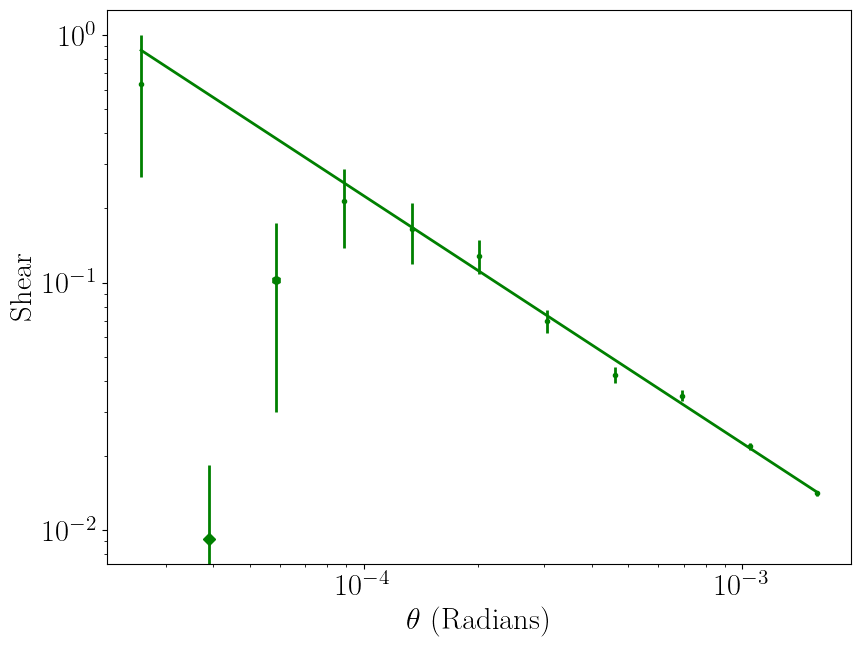

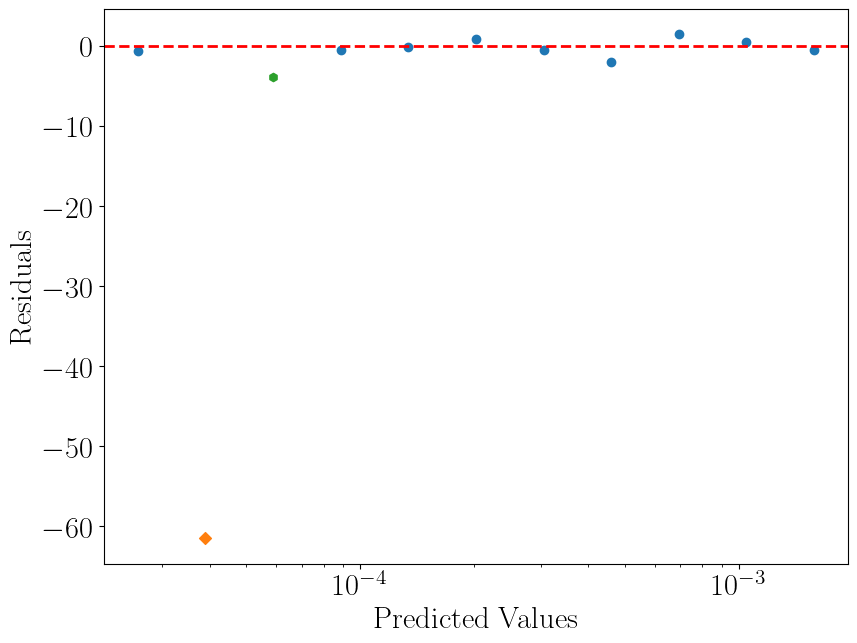

1.4142135623730951


In [1310]:
# plt.scatter(tangential_shear_ring_average_pure[0], tangential_shear_ring_average_pure[1])
c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_pure, "Tangential_Shear_Ring_Average (Pure) vs Theta", r"$\theta$ (Radians)", "Shear", "g", "tangential_shear_ring_average_pure")
plt.show() # Comment this to combine plots

print(tangential_shear_ring_average_pure[1][2]/tangential_shear_ring_average_pure[2][2])

In [1311]:
einstien_radius.append(EinsteinRadius(c, c_err))
velocity_dispersion.append(VelocityDispersion(D_s, D_ds, einstien_radius[0][0], einstien_radius[0][1]))
mass.append(Mass(D_d, velocity_dispersion[0][0], velocity_dispersion[0][1], einstien_radius[0][0], einstien_radius[0][1]))

print("Einstein Radius = ", einstien_radius[0][0], "+-", einstien_radius[0][1])
print("Velocity Dispersion = ", velocity_dispersion[0][0], "+-", velocity_dispersion[0][1])
print("Mass", mass[0][0].to(u.Msun), "+-", mass[0][1].to(u.Msun))

Einstein Radius =  4.479073876892663e-05 +- 2.8734833013747947e-06
Velocity Dispersion =  849587.1809878625 m / s +- 27252.001694202147 m / s
Mass 21696926392173.633 solMass +- 1968492051283.2996 solMass


#### Noise

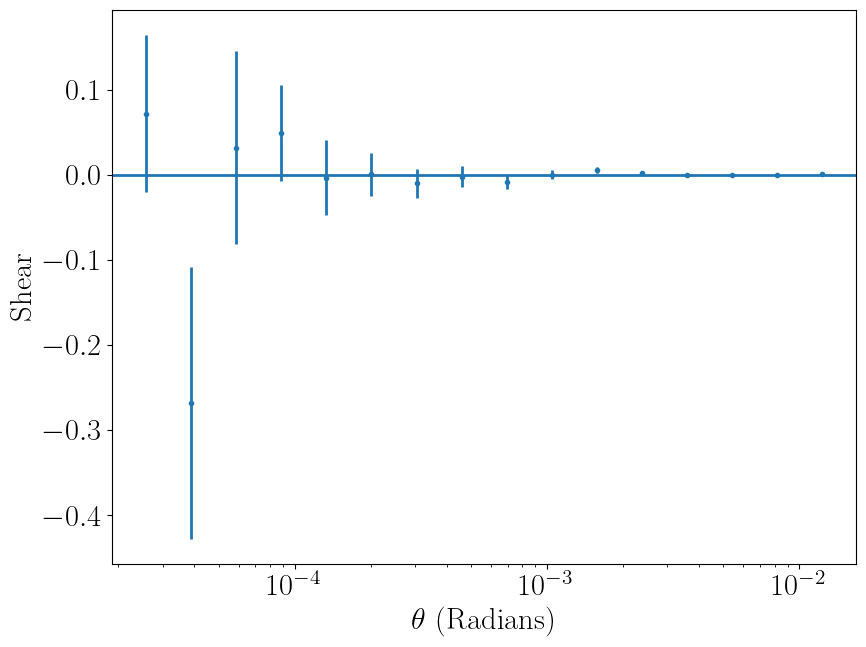

In [1312]:
# c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_noise, "Tangential_Shear_Ring_Average vs Theta", r"$\theta$ (Radians)", "Shear", "r", "tangential_shear_ring_average_noise")
plt.errorbar(tangential_shear_ring_average_noise[0], tangential_shear_ring_average_noise[1], yerr=tangential_shear_ring_average_noise[2], fmt=".")
plt.axhline(0)

# plt.title("Tangential_Shear_Ring_Average (Noise) vs Theta")
plt.xlabel(r"$\theta$ (Radians)")
plt.ylabel("Shear")
plt.xscale("log")

plt.show() # Comment this to combine plots

In [1313]:

# einstien_radius.append(EinsteinRadius(c, c_err))
# velocity_dispersion.append(VelocityDispersion(D_s, D_ds, einstien_radius[1][0], einstien_radius[1][1]))
# mass.append(Mass(D_d, velocity_dispersion[1][0], velocity_dispersion[1][1], einstien_radius[1][0], einstien_radius[1][1]))

# print("Einstein Radius = ", einstien_radius[1][0], "+-", einstien_radius[1][1])
# print("Velocity Dispersion = ", velocity_dispersion[1][0], "+-", velocity_dispersion[1][1])
# print("Mass", mass[1][0].to(u.Msun), "+-", mass[1][1].to(u.Msun))

#### Noise + Pure

a0:= -9.9999219 ; Err_a0 :=  0.4700473
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.3582833, number of degrees of freedom:=  10


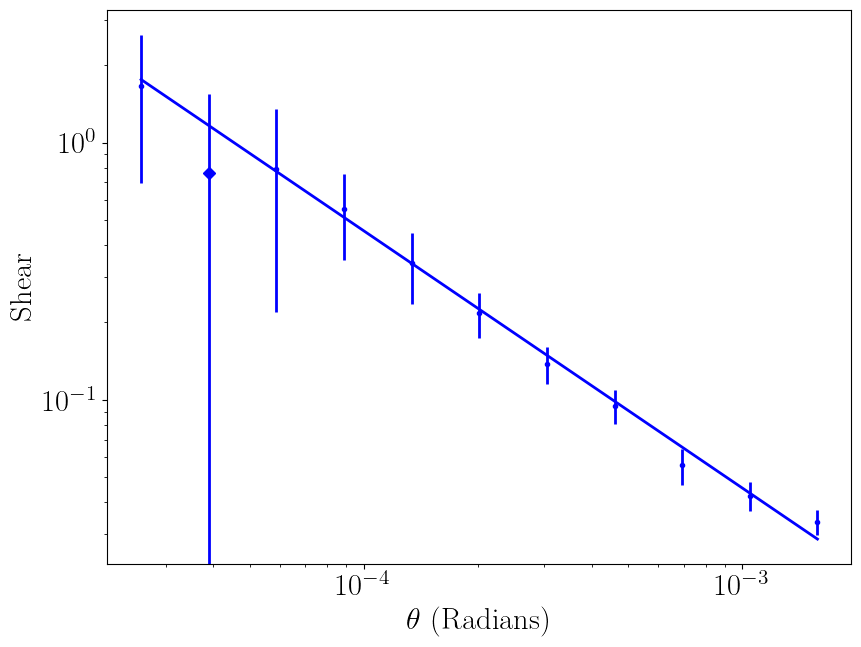

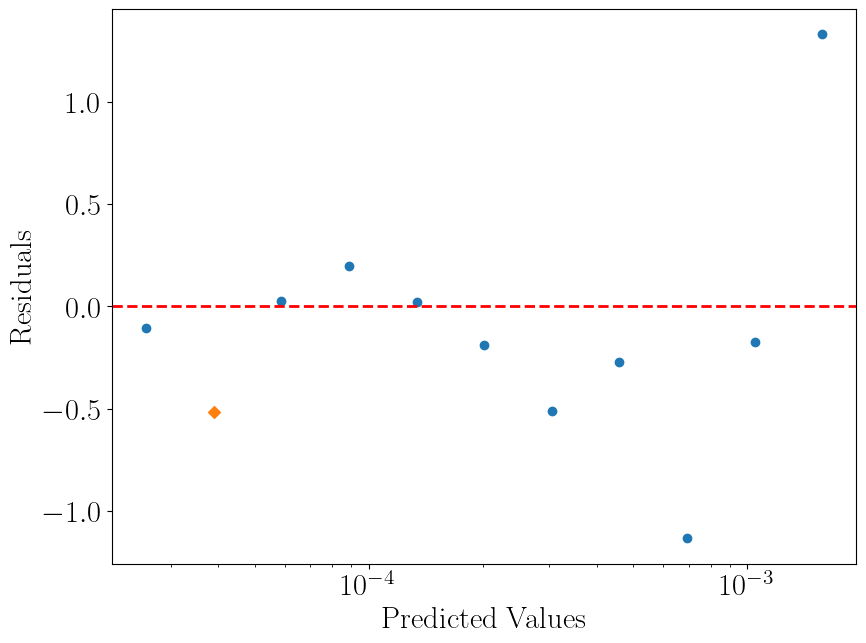

In [1314]:
c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_noise_pure, "Tangential_Shear_Ring_Average (Pure + Noise) vs Theta", r"$\theta$ (Radians)", "Shear", "b", "tangential_shear_ring_average_noise_pure")
plt.show() # Comment this to combine plots

In [1315]:
einstien_radius.append(EinsteinRadius(c, c_err))
velocity_dispersion.append(VelocityDispersion(D_s, D_ds, einstien_radius[1][0], einstien_radius[1][1]))
mass.append(Mass(D_d, velocity_dispersion[1][0], velocity_dispersion[1][1], einstien_radius[1][0], einstien_radius[1][1]))

print("Einstein Radius = ", einstien_radius[1][0], "+-", einstien_radius[1][1])
print("Velocity Dispersion = ", velocity_dispersion[1][0], "+-", velocity_dispersion[1][1])
print("Mass", mass[1][0].to(u.Msun), "+-", mass[1][1].to(u.Msun))

Einstein Radius =  9.080695019625008e-05 +- 2.1341781113173015e-05
Velocity Dispersion =  1209688.0293401685 m / s +- 142152.6495582582 m / s
Mass 89178455014018.6 solMass +- 29640567429002.43 solMass


#### Show Plots

In [1316]:
plt.show()

### Kappa Calculations

In [1317]:
mag_theta = np.array([])
for t in theta:
    mag_theta = np.append(mag_theta, np.linalg.norm(t))

### Kappa Plots

#### Pure

Pure
Velocity Dispersion =  849587.1809878625 m / s
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
a0:= -10.7068574 ; Err_a0 :=  0.1283035
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.0090950, number of degrees of freedom:=  10
a0:= -10.0137103 ; Err_a0 :=  0.1283035
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.0090950, number of degrees of freedom:=  10
a0:= -10.0137103 ; Err_a0 :=  0.1283035
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.0090950, number of degrees of freedom:=  10


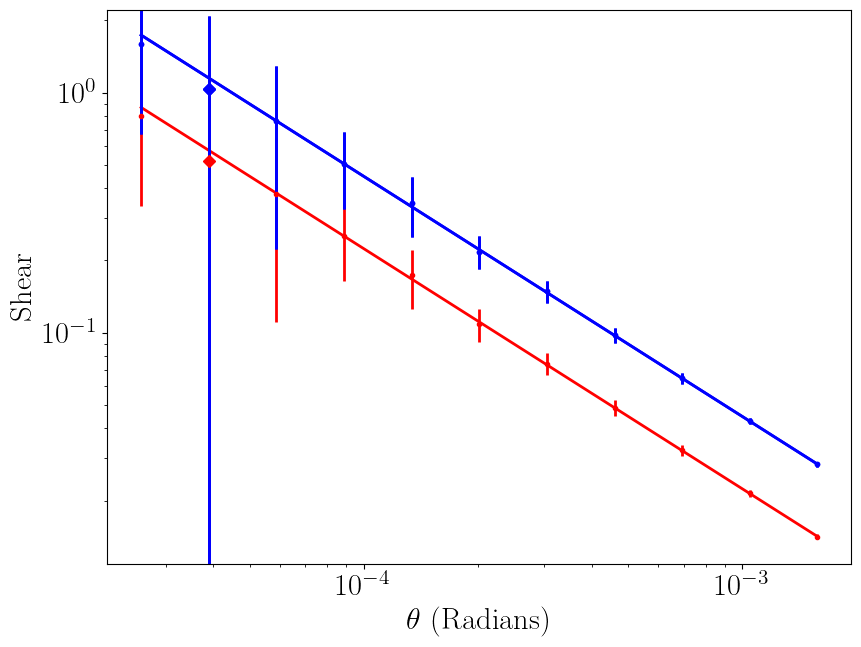

In [1318]:
# Pure
print("Pure")
print("Velocity Dispersion = ", velocity_dispersion[0][0])

kappa_ring_average   = KappaRingAverage(theta_array, einstien_radius[0][0], "pure")
kappa_bars           = KappaBar(theta_array, einstien_radius[0][0], "pure")
kappa_bar_minus_ring = [kappa_bars[0], kappa_bars[1] - kappa_ring_average[1], np.sqrt(kappa_bars[2]**2 + kappa_ring_average[2]**2)]

PlottingFunction(kappa_ring_average, "Kappa_Ring_Average and Kappa_Bar vs Theta (Pure)", r"$\theta$ (Radians)", "Shear", "r", "kappa_ring_average")
PlottingFunction(kappa_bars, "Kappa_Ring_Average and Kappa_Bar vs Theta (Pure)", r"$\theta$ (Radians)", "Shear", "b", "kappa_bar")
PlottingFunction(kappa_bars, "Kappa_Ring_Average - Kappa_Bar vs Theta (Pure)", r"$\theta$ (Radians)", "Shear", "b", "Kappa_Ring_Average - Kappa_Bar vs Theta (Pure)")


plt.show()


In [1319]:
# tangential_shear_ring_average_pure = [tangential_shear_ring_average_pure[0], tangential_shear_ring_average_pure[1], tangential_shear_ring_average_pure[2]]
# c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_pure, "Tangential_Shear_Ring_Average vs Theta", r"$\theta$ (Radians)", "tangential_shear_ring_average_pure", "b", "tangential_shear_ring_average_pure")
# # PlottingFunction(kappa_ring_average, "(Kappa_Bar - Kappa_Ring_Average) and Tangential_Shear_Ring_Average (Pure)", r"$\theta$ (Radians)", "(kappa_bar - kappa_ring_average)", "g", "(kappa_bar - kappa_ring_average)")
# # plt.show()

#### Noise

Noise
Velocity Dispersion =  1209688.0293401685 m / s
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
16
3
1
2
8
13
40
89
172
377
952
2037
4719
10736
24234
47626
8072
a0:= -10.0296852 ; Err_a0 :=  0.3246053
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.1787930, number of degrees of freedom:=  11
a0:= -9.3365380 ; Err_a0 :=  0.1623026
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.7151720, number of degrees of freedom:=  11


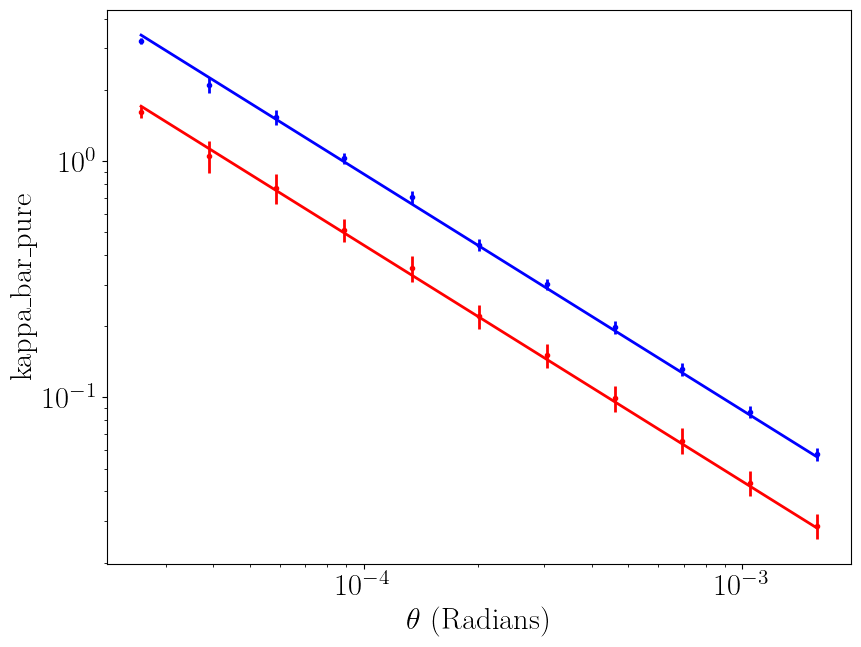

In [1320]:
# Noise
print("Noise")
print("Velocity Dispersion = ", velocity_dispersion[1][0])

kappa_ring_average   = KappaRingAverage(mag_theta, einstien_radius[1][0], "noise")
kappa_bars           = KappaBar(mag_theta, einstien_radius[1][0], "noise")
kappa_bar_minus_ring = [kappa_bars[0], kappa_bars[1] - kappa_ring_average[1], np.sqrt(kappa_bars[2]**2 + kappa_ring_average[2]**2)]

PlottingFunction(kappa_ring_average, "Kappa_Ring_Average and Kappa_Bar vs Theta (Noise)", r"$\theta$ (Radians)", "kappa_ring_average_pure", "r", "kappa_ring_average")
PlottingFunction(kappa_bars, "Kappa_Ring_Average and Kappa_Bar vs Theta (Noise)", r"$\theta$ (Radians)", "kappa_bar_pure", "b", "kappa_bar")
plt.show()

a0:= -10.0296852 ; Err_a0 :=  0.4590612
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.0893965, number of degrees of freedom:=  11


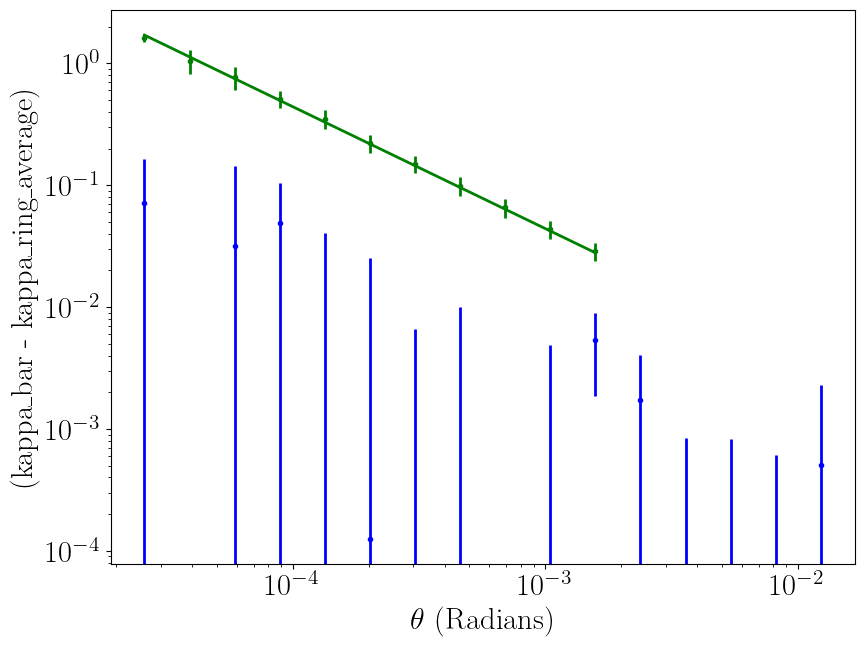

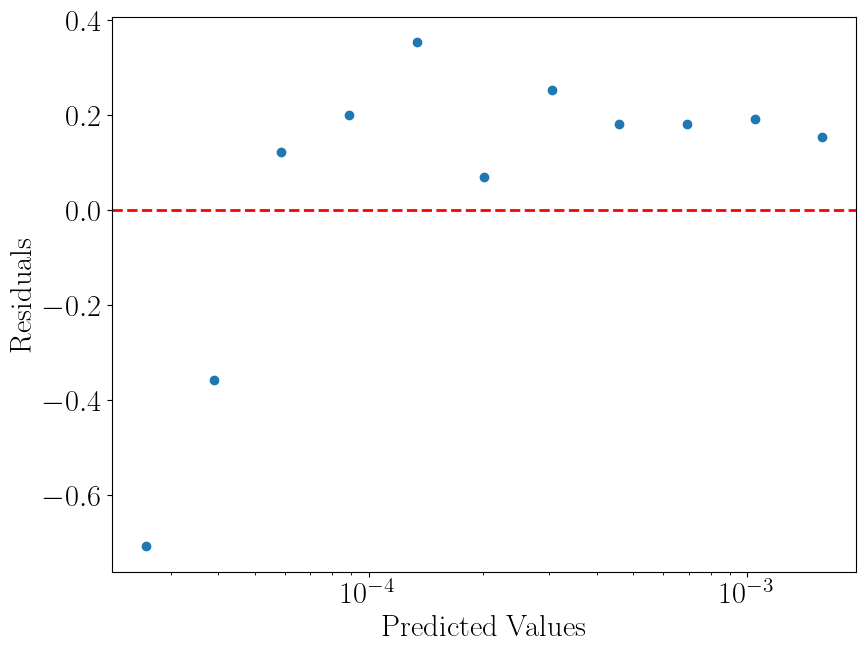

In [1321]:
c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_noise, "(Kappa_Bar - Kappa_Ring_Average) and Tangential_Shear_Ring_Average (Noise)", r"$\theta$ (Radians)", "tangential_shear_ring_average_pure", "b", "tangential_shear_ring_average_noise")
PlottingFunction(kappa_bar_minus_ring, "(Kappa_Bar - Kappa_Ring_Average) and Tangential_Shear_Ring_Average (Noise)", r"$\theta$ (Radians)", "(kappa_bar - kappa_ring_average)", "g", "(kappa_bar - kappa_ring_average) (Noise)")
plt.show()

#### Noise + Pure

In [1322]:
# Pure + Noise
print("Pure + Noise")
print("Velocity Dispersion = ", velocity_dispersion[2][0])

kappa_ring_average   = KappaRingAverage(mag_theta, einstien_radius[2][0], "noise + pure")
kappa_bars           = KappaBar(mag_theta, einstien_radius[2][0], "noise + pure")
kappa_bar_minus_ring = [kappa_bars[0], kappa_bars[1] - kappa_ring_average[1], np.sqrt(kappa_bars[2]**2 + kappa_ring_average[2]**2)]

PlottingFunction(kappa_ring_average, "Kappa_Ring_Average and Kappa_Bar vs Theta (Pure + Noise)", r"$\theta$ (Radians)", "kappa_ring_average_pure", "r", "kappa_ring_average (Pure + Noise)")
PlottingFunction(kappa_bars, "Kappa_Ring_Average and Kappa_Bar vs Theta (Pure + Noise)", r"$\theta$ (Radians)", "kappa_bar_pure", "b", "kappa_bar (Pure + Noise)")
plt.show()

Pure + Noise


IndexError: list index out of range

a0:= -9.9999219 ; Err_a0 :=  0.4772092
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.3582833, number of degrees of freedom:=  10


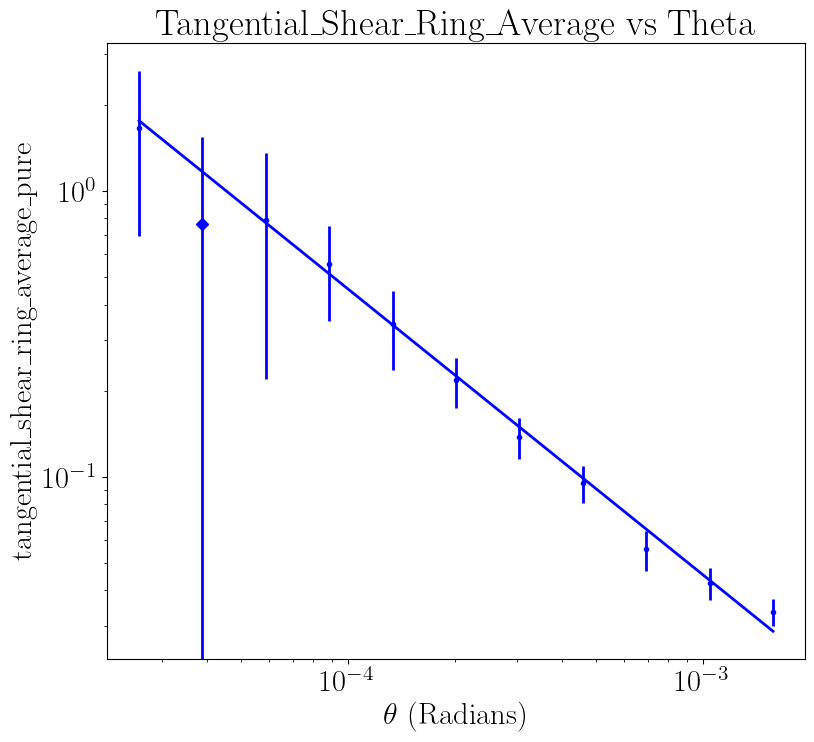

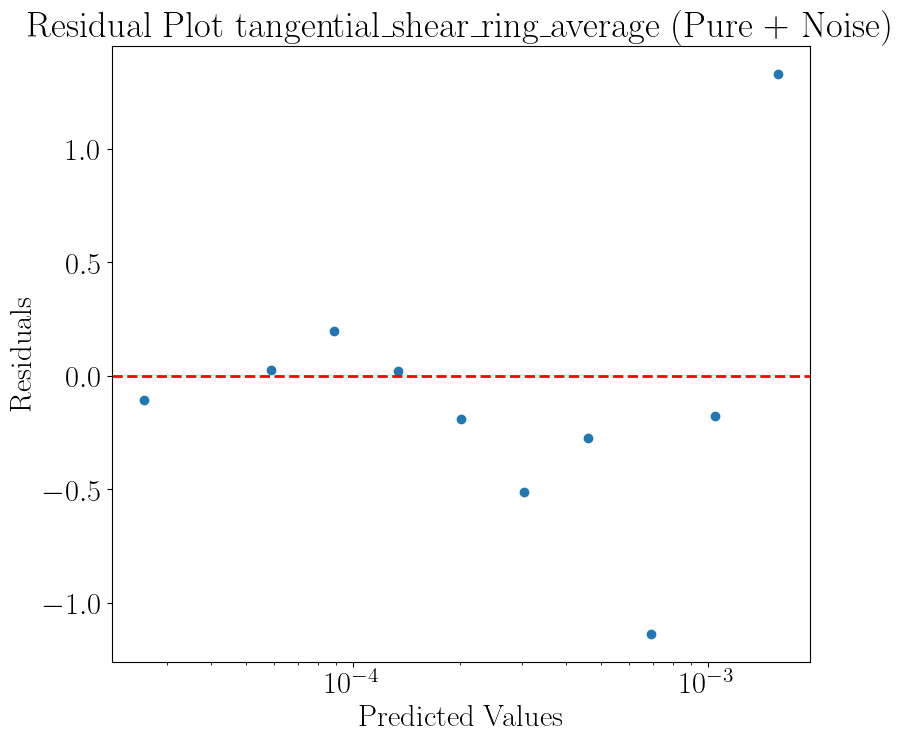

a0:= -10.0296852 ; Err_a0 :=  0.2042992
a1:= -1.0000000    1 / rad ; Err_a1 :=  0.0000000    1 / rad
Reduced Chisquare for model A:=      0.1787930, number of degrees of freedom:=  11


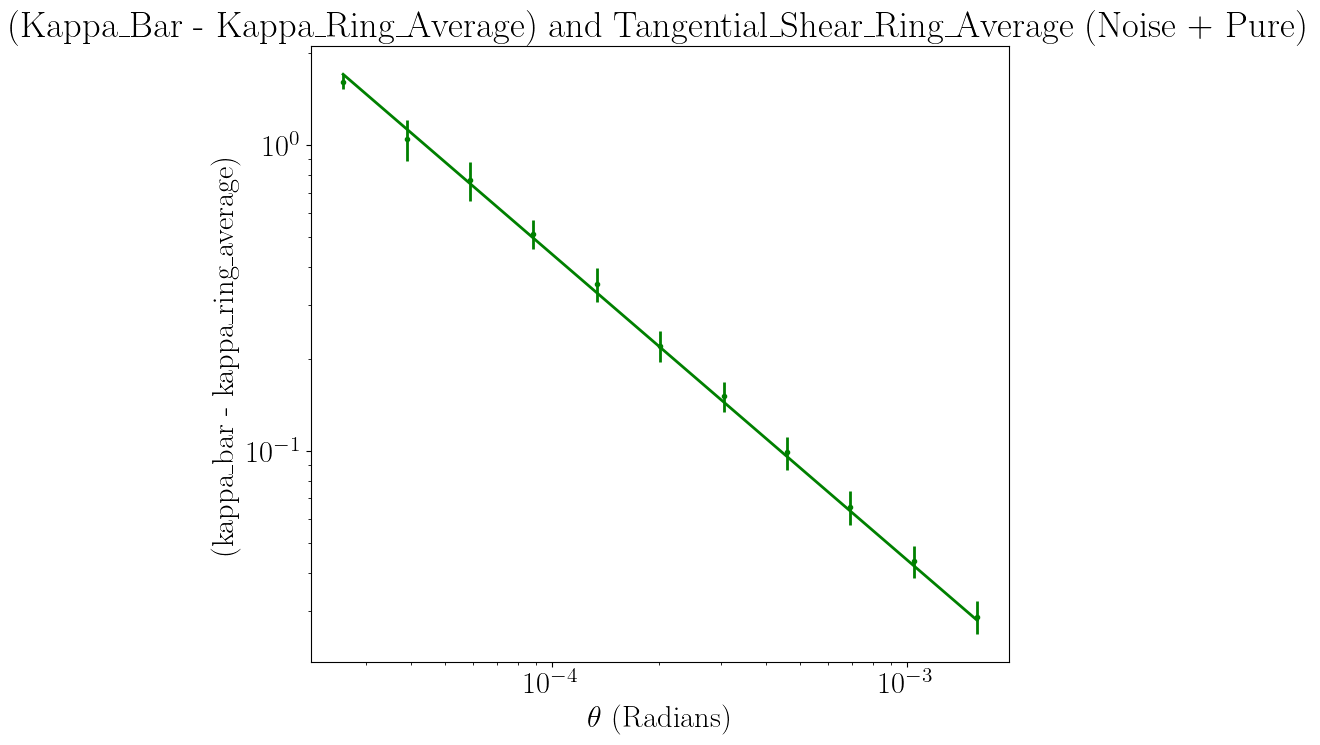

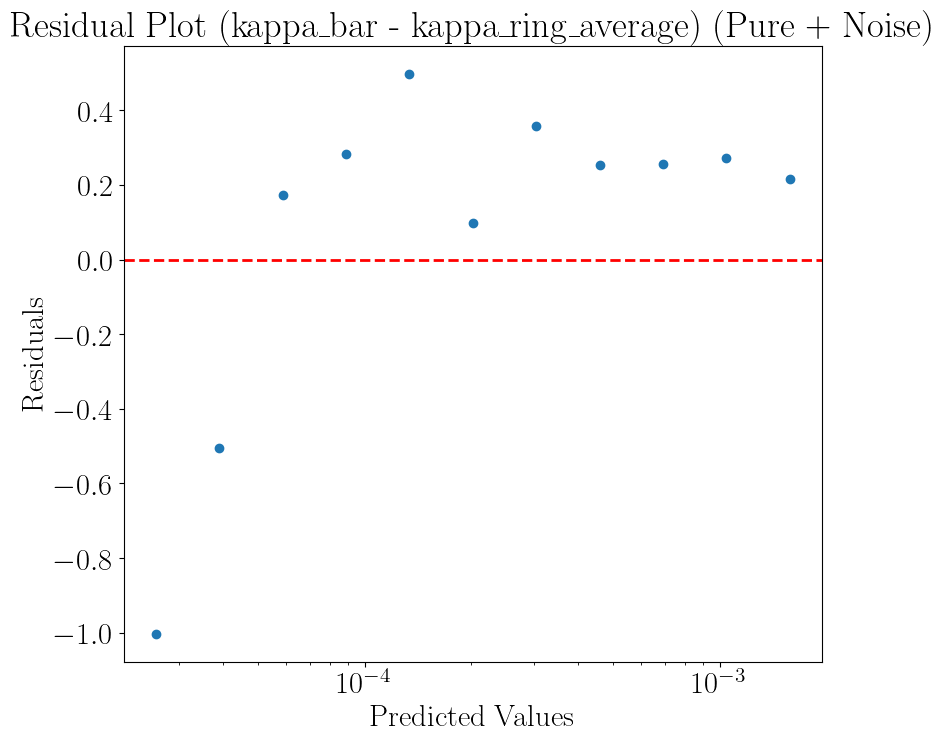

In [ ]:
c, m, c_err, m_err = PlottingFunction(tangential_shear_ring_average_noise_pure, "Tangential_Shear_Ring_Average vs Theta", r"$\theta$ (Radians)", "tangential_shear_ring_average_pure", "b", "tangential_shear_ring_average (Pure + Noise)")
PlottingFunction(kappa_ring_average, "(Kappa_Bar - Kappa_Ring_Average) and Tangential_Shear_Ring_Average (Noise + Pure)", r"$\theta$ (Radians)", "(kappa_bar - kappa_ring_average)", "g", "(kappa_bar - kappa_ring_average) (Pure + Noise)")
plt.show()

### Calculation of the Critical Surface Mass Density

In [ ]:
# Convert our units from Mpcˆ-1 to mˆ-1
sig_crit = CriticalSurfaceMassDensity(D_s, D_d, D_ds)

print("Critcal Surface Mass Density", sig_crit)

Critcal Surface Mass Density 8.516597115863421 kg / m2


### Surface Mass Density Function

In [ ]:
def SurfaceMassDensity(theta, D_d, A):
    """
    Return the surface mass density at a given theta

    Parameters:

        theta : float array
        Distance from the origin in radians 

        D_d : float
        Distance from origin to lens measrued in in Mpc
    
    Returns:

        surface_mass_density : float
        surface mass density at a given theta

    """

    xi = theta * D_d

    return (A * np.pi) / xi




